# Flood Detector Preprocessing Notebook
This is a first draft of the Flooding Detector Preprocessing. The detector will use a pretrained model (*MobileNetV2*) to detected floodings on satellite imagery. The Training data (*Sen1Floods11*) is provived by the company *CloudToStreet* and was downloaded from Google Cloud Service.

Please take a look at the notebook `FloodDetectorTrain.ipynb` to get an overview about the model design and training.

**Note**: How to connect via SHH: <br>
```
jupyter notebook --no-browser --port xxxx
ssh -NL xxxx:localhost:xxxx 192.168.0.xxx
```

In [1]:
%matplotlib inline

## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.config as tfconf

### Custom Imports

In [3]:
import daPro
import customMetrics as cMetrics
import customCallbacks as cCallbacks
import floodDetectorModel as floodDetector

#import importlib
#importlib.reload(floodDetector)
#importlib.reload(daPro)
#importlib.reload(cMetrics)

In [4]:
tfconf.list_physical_devices('GPU')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

---
## Constants

In [5]:
### Paths ###
DS_PATH_ROOT = "../../Sen1Floods11/data/v1.1/"
DATA_PATH_ROOT = DS_PATH_ROOT + "data/"
DATA_PATH_IMAGES = DATA_PATH_ROOT + "flood_events/HandLabeled/S1Hand/"
DATA_PATH_LABELS = DATA_PATH_ROOT + "flood_events/HandLabeled/LabelHand/"

DS_PATH_SPLIT = DS_PATH_ROOT + "splits/flood_handlabeled/"
DS_PATH_SPLIT_TRAIN = DS_PATH_SPLIT + "flood_train_data.csv"
DS_PATH_SPLIT_VALID = DS_PATH_SPLIT + "flood_valid_data.csv"
DS_PATH_SPLIT_TEST  = DS_PATH_SPLIT + "flood_test_data.csv"

# proof path existence
assert os.path.exists(DATA_PATH_ROOT), DATA_PATH_ROOT + " does not exist"

---
## Load Data
Load Images as Numpy Arrays and plot random images. <br>

The data is Raw Sentinel-1 imagery of *IW mode* and *dual polarisation*. Hence, 2 channels are available: 
- Band 1 is of `VV` Polarisation
- Band 2 is of `VH` Polarisation
- Additionally, we will create a composite band Nr 3: It will highlight the transition interval between water and no water pixels (backscatter values `[-20dB .. 0dB]` of `VV` Polarisation) in a higher resolution. There is the largest distribution overlap. Anyway, we have to provide a third channel since we will use transfer learning and the pretrained model expects an input of dimension 3.

The product is of *GRD (Ground Range Detected)* type. The data is of type `float32`, the values represent the *backscatter coefficient* and are scaled in `dB`. Width and height are `512` pixels, spatial resoultion is `10m` and the datafromat is `GeoTIFF`. <br>

The hand labeled ground truth images have 3 labels:
- `-1` : No Data / Not Valid
- ` 0` : Not Water
- ` 1` : Water.

After reviewing some labelled images, there does not appear to be an underlying pattern when a pixel is labelled as "No Data". Therefore, no attempt should be made to predict the "No Data" class and hence, a misclassification should not be penalised. 

In general, the higher the backsacttered intensity, the rougher is the surface being imaged (See [Here](https://crisp.nus.edu.sg/~research/tutorial/sar_int.htm) for a quick intro into interpreting SAR images). Hence, calm water surfaces appear with a low backscatter coeffiecient. Anayway, other flat surfaces like pave roads are represented with low coefficents, too. The data should be processed keeping that in mind.

In [6]:
imageLoader = daPro.ImageLoader(DATA_PATH_IMAGES, DATA_PATH_LABELS, tile_factor=None)

ds_train_Img, ds_train_GT = imageLoader.load_ds(DS_PATH_SPLIT_TRAIN)
ds_valid_Img, ds_valid_GT = imageLoader.load_ds(DS_PATH_SPLIT_VALID)
ds_test_Img, ds_test_GT   = imageLoader.load_ds(DS_PATH_SPLIT_TEST)

252  Images were found.
89  Images were found.
90  Images were found.


Shape of Training Image Array:  (252, 512, 512, 3)


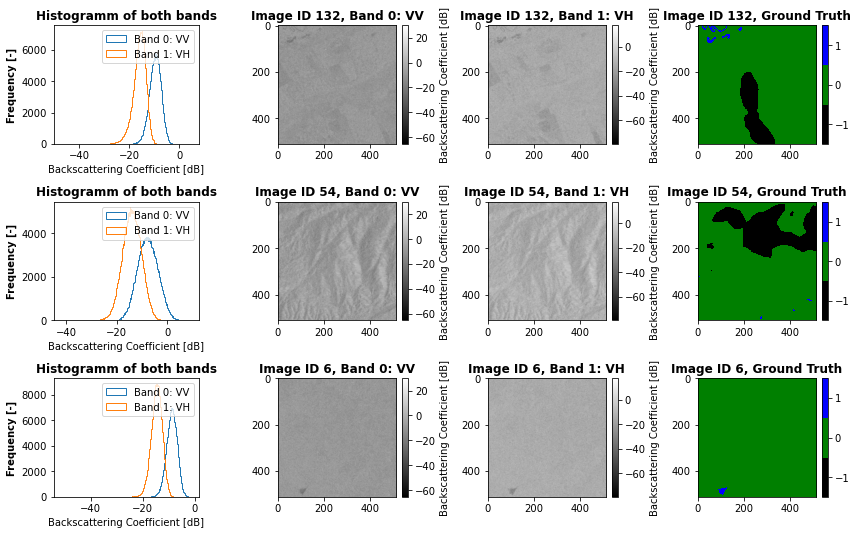

In [7]:
daPro.plot_rand_imgs(3, ds_train_Img, ds_train_GT, pos_bound=False);
print("Shape of Training Image Array: ", ds_train_Img.shape)

Let's take a look at the pixel distribution per Label for all the training data

Pixel Distribution: No Data: 0.13, No Water: 0.78, Water: 0.08.
Recommended Weights:  [0, 1, 9.52010993136633] 



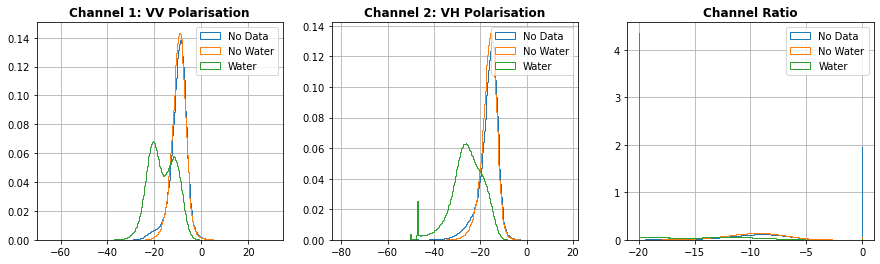

In [8]:
daPro.plot_pixel_dstr_per_ch(ds_train_Img, ds_train_GT)

Is the validation and test data distributed smiliary?

In [14]:
fracs = []
for l in [-1, 0, 1]:
    fracs.append(ds_valid_GT[ds_valid_GT==l].size / ds_valid_GT.size)
    fracs.append(ds_test_GT[ds_test_GT==l].size / ds_test_GT.size)

print(f"Pixel Distribution of Validation Set: \t No Data: {fracs[0]:.2f}, No Water: {fracs[2]:.2f}, Water: {fracs[4]:.2f}.")
print(f"Pixel Distribution of Test Set: \t No Data: {fracs[1]:.2f}, No Water: {fracs[3]:.2f}, Water: {fracs[5]:.2f}.")

Pixel Distribution of Validation Set: 	 No Data: 0.13, No Water: 0.77, Water: 0.10.
Pixel Distribution of Test Set: 	 No Data: 0.13, No Water: 0.76, Water: 0.11.


---
## Preprocess Images
Before training and inference, the images must be preprocessed. Three things in particular need to be taken into account:
- The images contain NaN pixels, which would lead to problems during training. `NaN` Pixels are marked **red** in the grey SAR colormaps (see below).
- Furthermore, the training data should be normalised to the range [-1 ... 1] to fulfill the Keras Transfer Learning input requirements.
- The ground truth labels should be non-negative integer values.

### Handle NaNs
We can replace `NaNs` with a numerical number. **But which number should we use as a replacement?** 

From reviewing some Images, which contain `NaN` values, it seems like that `NaN` Values are usually either `No-Data Pixels` or `Non-Water` pixels. Therefore, the replace-value should not be near the SAR-Value of water surfaces, as this could lead to false classifications. Possibly, the best approach could be to set `NaN` pixels to a value greater or equal to 0, to indicate that it is far away from water surfaces. Note that water is only represented by low backscatter coeffiecients when the water surface is flat!

In the *first Flood Detector Version*, a value of `0` is assumed.

Max and Min Values of some random images.
img 3 	 Max: 1.67, 	 Min: -29.26, 	 Type float32
img 4 	 Max: -0.77, 	 Min: -21.89, 	 Type float32
img 5 	 Max:  nan, 	 Min:  nan, 	 Type float32
img 6 	 Max: -1.07, 	 Min: -35.05, 	 Type float32

Found 23 images containing NaN values. Below are 3 of them.


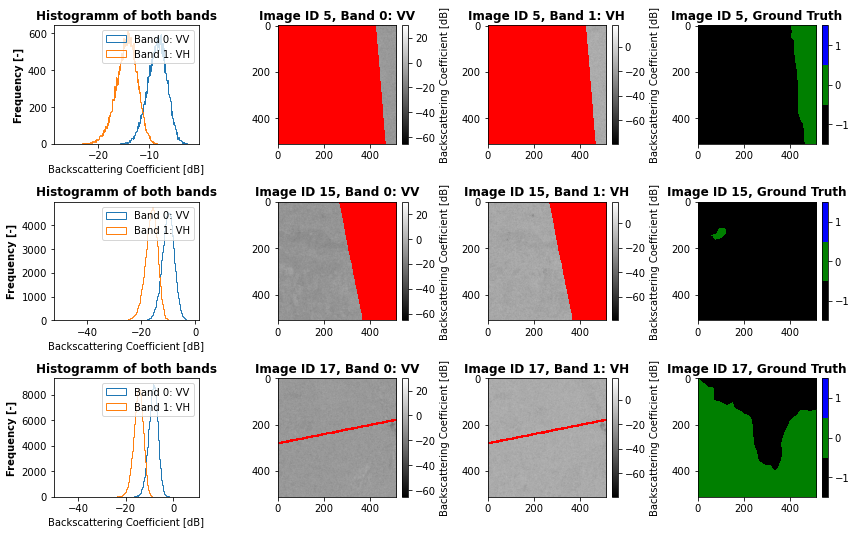

In [9]:
print("Max and Min Values of some random images.")
for i, img in enumerate(ds_train_Img[3:7]):
    print(f"img {i+3} \t Max: {img[:,:,0].max():4.2f}, \t Min: {img[:,:,0].min():4.2f}, \t Type {img.dtype}")# Find all Images with NaN Values

# Find all Images with NaN Values
imgs_with_NaN = []
for i, img in enumerate(ds_train_Img):
    if np.isnan(np.sum(img)).any() and not np.isnan(img[...,0]).all() and not np.isnan(img[...,1]).all():
        imgs_with_NaN.append(i)

print(f"\nFound {len(imgs_with_NaN)} images containing NaN values. Below are 3 of them.")

daPro.plot_rand_imgs(3, ds_train_Img, ds_train_GT, id_of_interest=imgs_with_NaN[:3], pos_bound=False);

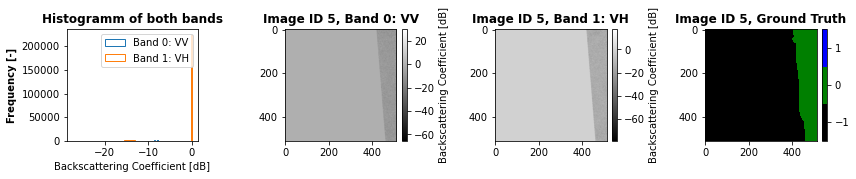

In [10]:
nan = 0
np.nan_to_num(ds_train_Img, copy=False, nan=nan)
np.nan_to_num(ds_valid_Img, copy=False, nan=nan)
np.nan_to_num(ds_test_Img, copy=False, nan=nan);

daPro.plot_rand_imgs(1, ds_train_Img, ds_train_GT, id_of_interest=[5], pos_bound=False);

### Normalization
The histograms show that some backscatter coeffiecients are more frequent represented than others. Actually, they are gaussian distributed. It cloud be efficient to feed them into the network without normalization. Anyway, we will try some Normalization Procedures.

Observations have shown that SAR values of water surface are distributed around `-30 dB` for VH polarisation and at `-20 dB` for VV polarisation. No-Water pixels are usally higher valued. 

Additionally, we want to scale the values to the range [-1 .. 1]

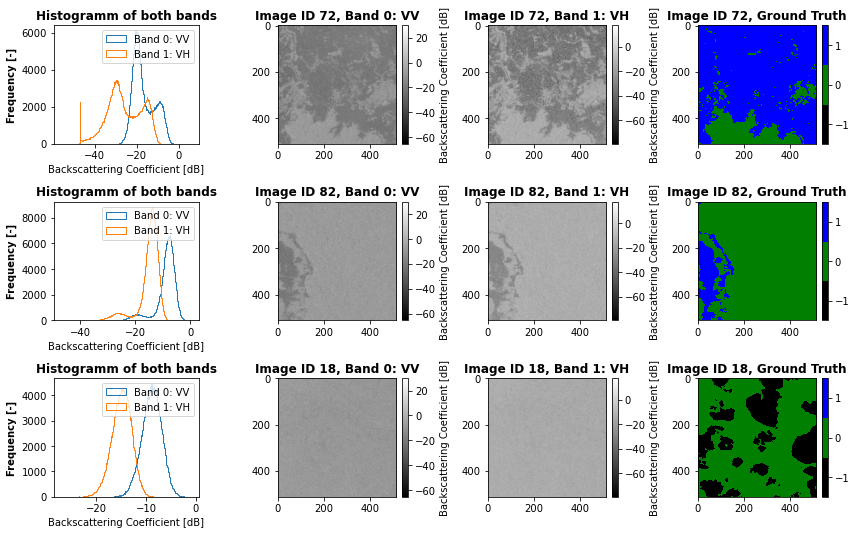

In [11]:
daPro.plot_rand_imgs(3, ds_train_Img, ds_train_GT, id_of_interest=[72, 82, 18], pos_bound=False);

An easy and fast way to normalize would be to clip the SAR data channel-wise to a range und scale it linear in there to [-1 ..1]

In [12]:
vmin, vmax = ([-50, -50, -30], [0, 0, -10]) # ([-40, -50], [0, -5])
linearNorm = daPro.LinearNorm(vmin, vmax)

ds_train_Img_norm = linearNorm.norm(ds_train_Img)
ds_valid_Img_norm = linearNorm.norm(ds_valid_Img)
ds_test_Img_norm  = linearNorm.norm(ds_test_Img)

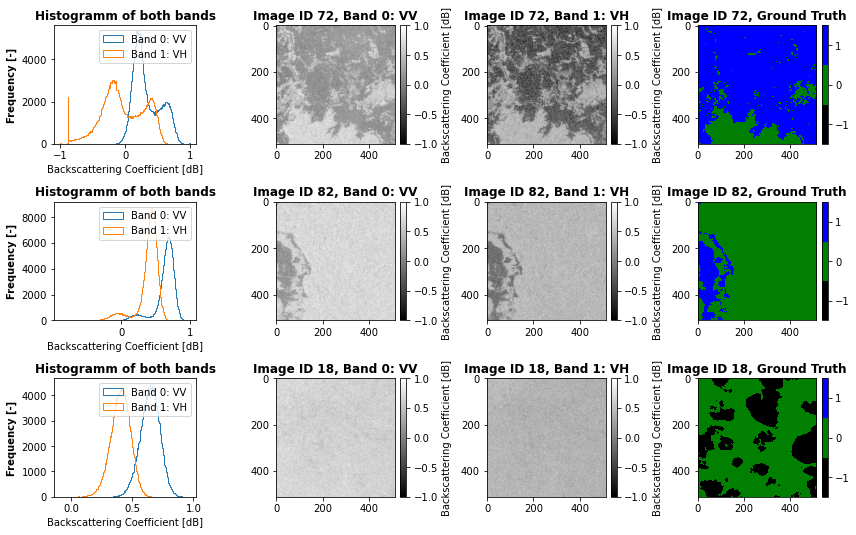

In [13]:
daPro.plot_rand_imgs(3, ds_train_Img_norm, ds_train_GT, id_of_interest=[72, 82, 18], pos_bound=False);

We can use alpha-percentiles to clip the data more reasonable.

In [14]:
linearNorm = daPro.LinearNorm.withPercentiles(ds_train_Img, 0.1, 99)

ds_train_Img_norm = linearNorm.norm(ds_train_Img)
ds_valid_Img_norm = linearNorm.norm(ds_valid_Img)
ds_test_Img_norm  = linearNorm.norm(ds_test_Img)

Min Scaling Limits:  [-29.26355601 -46.99043655 -30.        ]  - Max Scaling Limits:  [  0.   0. -10.]


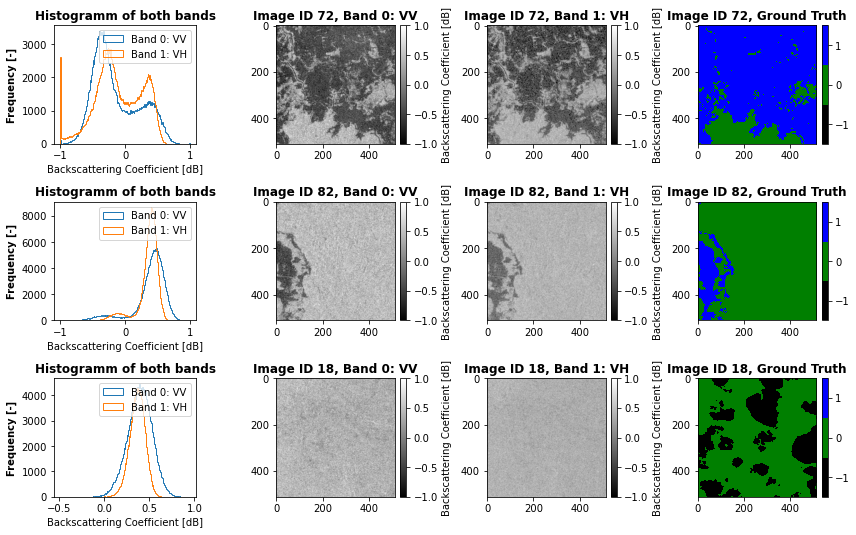

In [15]:
daPro.plot_rand_imgs(3, ds_train_Img_norm, ds_train_GT, id_of_interest=[72, 82, 18], pos_bound=False);

The bell shapes in the Histograms are a bit more stretched now to use more of the possible range. Anyway, they are not using the range efficient yet. We will try a **gaussian normalization** next. Note that the water class is underrepresented in the dataset. Therefore, gaussian normaliation is possibly not the best normalization.

In [16]:
gaussianNorm = daPro.GaussianNorm(ds_train_Img)

ds_train_Img_norm = gaussianNorm.norm(ds_train_Img)
ds_valid_Img_norm = gaussianNorm.norm(ds_valid_Img)
ds_test_Img_norm  = gaussianNorm.norm(ds_test_Img) 

Normalization Prameter - Mean:  [-10.184408, -16.895273, -17.004158] dB - Std:  [4.255339, 5.290568, 4.325274]  dB


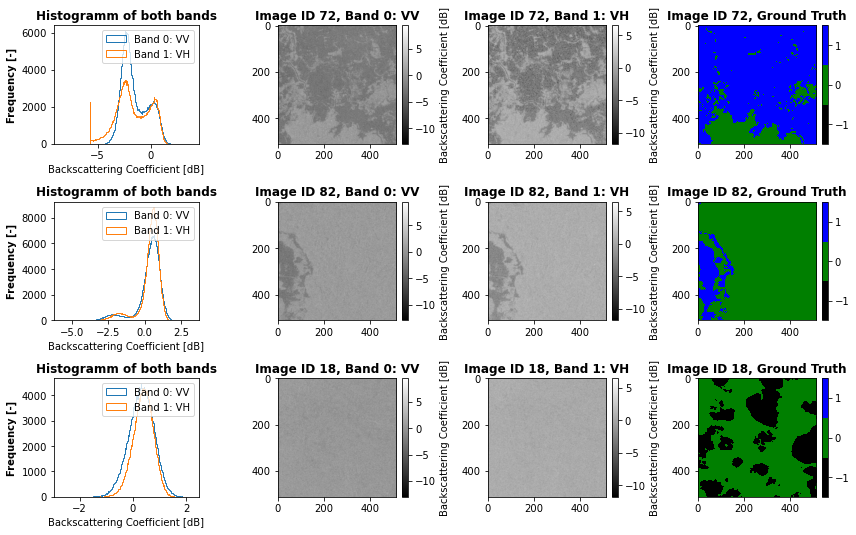

In [17]:
daPro.plot_rand_imgs(3, ds_train_Img_norm, ds_train_GT, id_of_interest=[72, 82, 18], pos_bound=False);

The Gaussian-Normalized data can be additionally scaled to the [-1 .. 1] range with the Percentile-Normalization

In [18]:
#linearNormPercentile = LinearNorm(v_min=[-6, -6], v_max=[2, 2]) 
linearNormPercentile = daPro.LinearNorm.withPercentiles(ds_train_Img_norm, perc_min=0.1, perc_max=99)

ds_train_Img_norm = linearNormPercentile.norm(ds_train_Img_norm)
ds_valid_Img_norm = linearNormPercentile.norm(ds_valid_Img_norm)
ds_test_Img_norm  = linearNormPercentile.norm(ds_test_Img_norm)

Min Scaling Limits:  [-4.4835786  -5.68845606 -3.00462866]  - Max Scaling Limits:  [2.39332461 3.19347072 1.61935592]


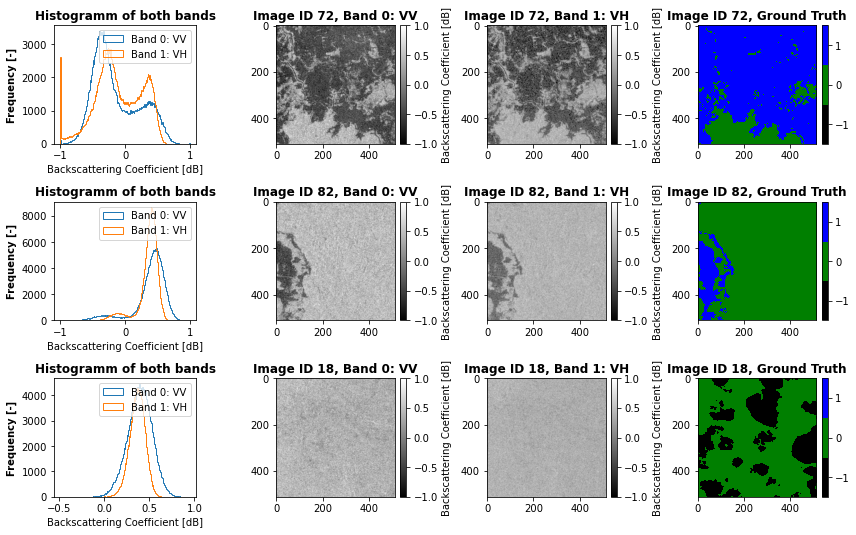

In [19]:
daPro.plot_rand_imgs(3, ds_train_Img_norm, ds_train_GT, id_of_interest=[72, 82, 18], pos_bound=False);

The best (at least visually) normalization results seem to be achieved with the linear scaling with alpha percentile. The Gaussian normalization does not seem to work well because the water and no-water classes are unevenly distributed. The nature of the gaussian normalization sees the rarer water class as at "outlier" and pulls it to the center of the distribution.

In [20]:
linearNorm = daPro.LinearNorm.withPercentiles(ds_train_Img, 0.1, 99)

ds_train_Img_norm = linearNorm.norm(ds_train_Img)
ds_valid_Img_norm = linearNorm.norm(ds_valid_Img)
ds_test_Img_norm  = linearNorm.norm(ds_test_Img)

Min Scaling Limits:  [-29.26355601 -46.99043655 -30.        ]  - Max Scaling Limits:  [  0.   0. -10.]


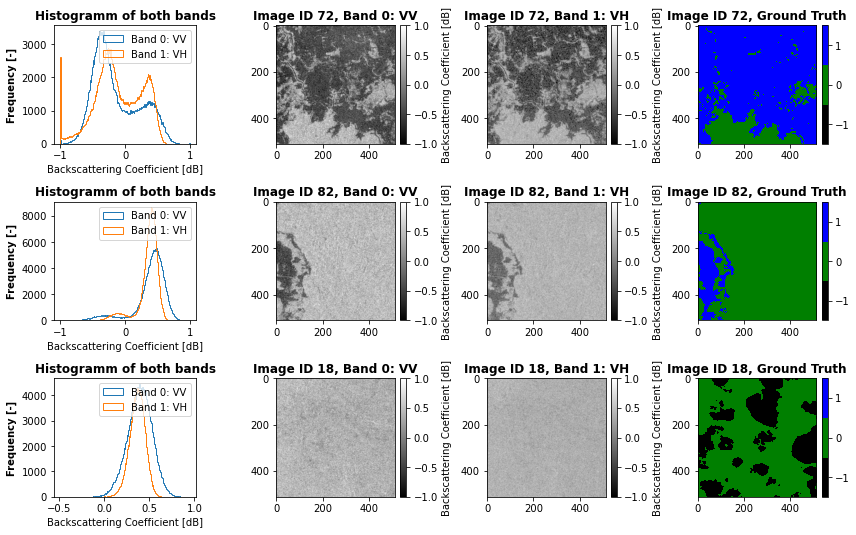

In [21]:
daPro.plot_rand_imgs(3, ds_train_Img_norm, ds_train_GT, id_of_interest=[72, 82, 18], pos_bound=False);

Pixel Distribution: No Data: 0.13, No Water: 0.78, Water: 0.08.
Recommended Weights:  [0, 1, 9.52010993136633] 



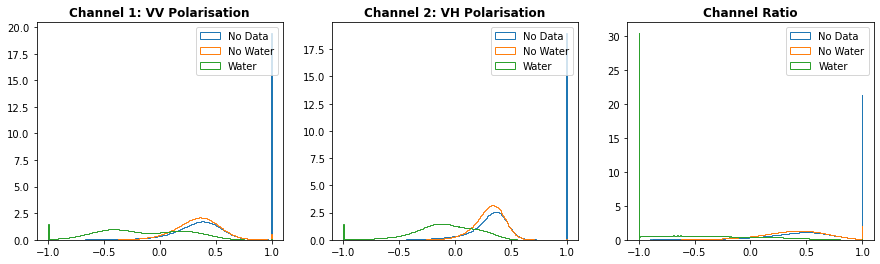

In [22]:
daPro.plot_pixel_dstr_per_ch(ds_train_Img_norm, ds_train_GT)

### Preprocess Labels
The next step is to push the Ground Truth Labels to positive values

In [23]:
# push gt labels to positive values
ds_train_GT_norm = ds_train_GT + 1
ds_valid_GT_norm = ds_valid_GT + 1
ds_test_GT_norm = ds_test_GT + 1

In [24]:
for i, img in enumerate(ds_train_GT_norm[:7]):
    print(f"img {i} \t Max: {img[:,:,0].max():4.2f}, \t Min: {img[:,:,0].min():4.2f}, \t Type {img.dtype}")

img 0 	 Max: 2.00, 	 Min: 0.00, 	 Type int16
img 1 	 Max: 2.00, 	 Min: 1.00, 	 Type int16
img 2 	 Max: 2.00, 	 Min: 1.00, 	 Type int16
img 3 	 Max: 2.00, 	 Min: 1.00, 	 Type int16
img 4 	 Max: 1.00, 	 Min: 0.00, 	 Type int16
img 5 	 Max: 1.00, 	 Min: 0.00, 	 Type int16
img 6 	 Max: 2.00, 	 Min: 1.00, 	 Type int16


### Sample Weights
As the data is not evenly distributed, we can use sample weights: Sample Weights can be set as an argument for the model.fit call. We can increase the weighting of the water-class during training to reach better results.

[0.16666667 0.33333334 0.5       ]


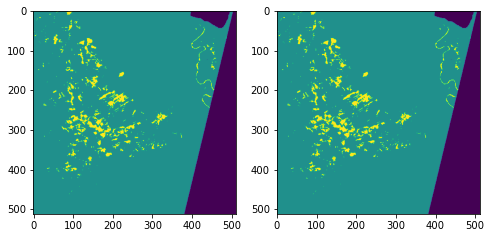

In [25]:
WEIGHTS = [1, 2, 3]
SAMPLE_WEIGHTS = daPro.create_sample_weights(ds_train_GT_norm, weights=WEIGHTS)

print(np.unique(SAMPLE_WEIGHTS))

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(ds_train_GT_norm[52]);
ax[1].imshow(SAMPLE_WEIGHTS[52]);

---
## Model Design

If you would like to get an overview about the model design and training, please take a look at the notebook `FloodDetectorTrain.ipynb`.